<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Inverse_Black_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black-Scholes Partial Differential Equation (PDE)
The value of an option $V(S, t)$ satisfies the Black-Scholes PDE:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

### Initial and Boundary Conditions of the Black-Scholes PDE

The initial and boundary conditions for the Black-Scholes PDE depend on the type of derivative being priced, such as European call or put options. These conditions are necessary for solving the PDE and obtaining specific option prices. We will consider a Call option.

- $\textbf{Initial Condition}$ (at $t = T$):
    - $\text{Call: } V(S, T) = \max(S - K, 0)$ \\
- $\textbf{Boundary Conditions:}$
  - $V(0, t) = 0$ \\
  - $V(S, t) \to S - K e^{-r(T-t)} \quad \text{as } S \to \infty$

These conditions, combined with the Black-Scholes PDE, provide a complete specification for determining the price of the option.


## Implementation

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

## Analytic formula

In [2]:
def black_scholes(S, t, T=1.0, K=120, r=0.05, sigma=0.20, option_type="call"):
    """
    Compute the Black-Scholes option price.

    Args:
        S (torch.Tensor): Current stock price.
        T (float): Time to maturity.
        t (float): Current time (typically 0).
        K (float): Strike price.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the stock price.
        option_type (str): "call" or "put".

    Returns:
        torch.Tensor: Option price.
    """
    # Ensure inputs are PyTorch tensors and have the correct dtype
    S = S.type(torch.float32) # Changed to type casting

    # Time to maturity
    tau = T - t

    # Avoid division by zero for tau = 0
    epsilon = 1e-8

    # Convert r and tau to tensors
    r = torch.tensor(r, dtype=torch.float32)
    tau = torch.tensor(tau, dtype=torch.float32)

    # Compute d1 and d2
    # Use tau and epsilon directly for torch.sqrt, no need to create new tensors
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * torch.sqrt(tau + epsilon))
    d2 = d1 - sigma * torch.sqrt(tau + epsilon)

    # Compute N(d1) and N(d2) using the cumulative distribution function
    N_d1 = 0.5 * (1.0 + torch.erf(d1 / torch.sqrt(torch.tensor(2.0))))
    N_d2 = 0.5 * (1.0 + torch.erf(d2 / torch.sqrt(torch.tensor(2.0))))

    # Compute the call or put price
    if option_type == "call":
        option_price = S * N_d1 - K * torch.exp(-r * tau) * N_d2
    elif option_type == "put":
        option_price = K * torch.exp(-r * tau) * (1.0 - N_d2) - S * (1.0 - N_d1)
    else:
        raise ValueError("Invalid option_type. Must be 'call' or 'put'.")

    return option_price

In [3]:
# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network for heat equation with Batch Normalization."""
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(2), # Inputs: (S, t)
            nn.Linear(2, 50),
            nn.ReLU(),

            nn.BatchNorm1d(50),
            nn.Linear(50, 50),
            nn.ReLU(),

            nn.BatchNorm1d(50),
            nn.Linear(50, 50),
            nn.ReLU(),

            nn.BatchNorm1d(50),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
def bs_pde_residual(model, S, t, r=0.05, sigma=0.20):
    """
    Compute the PDE residual for Black-Scholes equation:
    """
    S.requires_grad = True
    t.requires_grad = True
    V = model(torch.cat((S, t), dim=1))

    # Gradients w.r.t. x and t
    V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # Second-order derivative w.r.t. S
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]

    # PDE residual
    residual = V_t + 0.5*sigma**2*S**2*V_SS + r*S*V_S -r*V
    return residual

# Step 3: Define the loss function
def compute_loss(model, S_interior, t_interior,
                 S_boundary, t_boundary, V_boundary,
                 S_initial, t_initial, V_initial,
                 r, sigma, epoch=0):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""
    # PDE residual loss
    residual = bs_pde_residual(model, S_interior, t_interior, r, sigma)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss:
    # V(0, t)=0
    # V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞
    V_boundary_low_pred = model(torch.cat((S_boundary[0], t_boundary), dim=1))
    V_boundary_high_pred = model(torch.cat((S_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean((V_boundary_low_pred - V_boundary[0])**2) + \
              torch.mean((V_boundary_high_pred - V_boundary[1])**2)


    # Initial condition loss:
    # (at 𝑡=𝑇): 𝑉(𝑆,𝑇)=max(𝑆−𝐾,0)
    V_initial_pred = model(torch.cat((S_initial, t_initial), dim=1))
    ic_loss = torch.mean((V_initial_pred - V_initial)**2)

    if epoch % 100 == 0:
      print(f"Epoch {epoch}, PDE Loss: {pde_loss.item()}, BC Loss: {bc_loss.item()}, IC Loss: {ic_loss.item()}")

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, S_interior, t_interior,
               S_boundary, t_boundary, V_boundary,
               S_initial, t_initial, V_initial,
               r, sigma, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, S_interior, t_interior,
                            S_boundary, t_boundary, V_boundary,
                            S_initial, t_initial, V_initial,
                            r, sigma, epoch)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs,
                                        tolerance_grad=1e-7, tolerance_change=1e-9)

    lbfgs_iter = 0

    def closure():
        nonlocal lbfgs_iter
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, S_interior, t_interior,
                            S_boundary, t_boundary, V_boundary,
                            S_initial, t_initial, V_initial,
                            r, sigma, lbfgs_iter)
        loss.backward()
        lbfgs_iter += 1
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [8]:
S0 = 100.0
S_max = 150.0
S_min = 0.0
K = 100.0
T = 1.0
r = 0.05
sigma = 0.2

S = torch.linspace(0, S_max, 100).view(-1, 1)
t = torch.linspace(0, T, 100).view(-1, 1)

S = (S - S_min) / (S_max - S_min)
K = (K - S_min) / (S_max - S_min)


S_interior = torch.rand(100, 1) * S_max  # Uniformly sample S in [0, S_max]
t_interior = torch.rand(100, 1) * T      # Uniformly sample t in [0, T]

S_interior = (S_interior - S_min) / (S_max - S_min)

S_grid, t_grid = torch.meshgrid(S_interior.squeeze(), t_interior.squeeze(), indexing='ij')
S_interior = S_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

S_max_norm = (S_max - S_min) / (S_max - S_min)
S_min_norm = S_min / (S_max - S_min)

# Boundary points
# V(0, t)=0
# V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞
t_boundary = t
S_boundary = [torch.full_like(t, S_min), torch.full_like(t, S_max_norm)]
V_boundary = [torch.full_like(t, 0), S_max_norm - K * torch.exp(-r * (T - t))]


# Initial points
# (at 𝑡=𝑇): 𝑉(𝑆, 𝑇)=max(𝑆−𝐾, 0)
S_initial = S
t_initial = torch.full_like(t, T)
V_initial = torch.maximum(S - K, torch.tensor(0.0))

In [9]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, S_interior, t_interior,
           S_boundary, t_boundary, V_boundary,
           S_initial, t_initial, V_initial,
           r, sigma,
           adam_epochs=500, lbfgs_epochs=5000)

Epoch 0, PDE Loss: 0.0007433546124957502, BC Loss: 0.7847288250923157, IC Loss: 0.7938477993011475
Adam Epoch 0, Loss: 1.579319953918457
Epoch 100, PDE Loss: 0.00012883443559985608, BC Loss: 0.06401750445365906, IC Loss: 0.006627678871154785
Adam Epoch 100, Loss: 0.07077401876449585
Epoch 200, PDE Loss: 0.00010968423885060474, BC Loss: 0.06435231864452362, IC Loss: 0.006215446162968874
Adam Epoch 200, Loss: 0.07067745178937912
Epoch 300, PDE Loss: 9.702764509711415e-05, BC Loss: 0.06432916224002838, IC Loss: 0.006201779469847679
Adam Epoch 300, Loss: 0.07062797248363495
Epoch 400, PDE Loss: 8.72825548867695e-05, BC Loss: 0.064326710999012, IC Loss: 0.006198246963322163
Adam Epoch 400, Loss: 0.07061224430799484
Starting LBFGS optimization...
Epoch 0, PDE Loss: 8.057228842517361e-05, BC Loss: 0.06432553380727768, IC Loss: 0.0061961691826581955
Epoch 100, PDE Loss: 5.835722549818456e-05, BC Loss: 0.06432231515645981, IC Loss: 0.006192848086357117


In [10]:
# Step 7: Visualize the results
# Create a grid for prediction
S_pred = torch.linspace(S_min, S_max, 100).view(-1, 1)
t_pred = torch.linspace(0, T, 100).view(-1, 1)
S_grid_pred, t_grid_pred = torch.meshgrid(S_pred.squeeze(), t_pred.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Predict using the trained model
V_pred = model(torch.cat((S_flat, t_flat), dim=1)).detach().numpy()
V_pred = V_pred.reshape(100, 100)
V_pred

array([[0.01805313, 0.03762789, 0.05720373, ..., 0.00815209, 0.00881632,
        0.00948079],
       [0.01592453, 0.03152641, 0.05110105, ..., 0.03000124, 0.03066571,
        0.03132983],
       [0.01749082, 0.0315388 , 0.04558666, ..., 0.05185075, 0.05251487,
        0.05230208],
       ...,
       [0.29368278, 0.24619754, 0.20164417, ..., 0.12516157, 0.13096072,
        0.13284557],
       [0.29487017, 0.247386  , 0.22548957, ..., 0.10190599, 0.1082202 ,
        0.10759114],
       [0.2982421 , 0.26068428, 0.24861981, ..., 0.07301287, 0.07738258,
        0.08197917]], dtype=float32)

In [11]:
# black_scholes(S, t, T, K, r, sigma)
V_exact = black_scholes(S_flat, t_flat, T, K, r, sigma)
V_exact = V_exact.reshape(100, 100)
V_exact

<ipython-input-2-57165c588757>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau, dtype=torch.float32)


tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.8810,   0.8807,   0.8804,  ...,   0.8492,   0.8488,   0.8485],
        [  2.3962,   2.3958,   2.3955,  ...,   2.3643,   2.3640,   2.3636],
        ...,
        [146.3355, 146.3352, 146.3349,  ..., 146.3037, 146.3034, 146.3030],
        [147.8507, 147.8504, 147.8501,  ..., 147.8188, 147.8185, 147.8182],
        [149.3658, 149.3655, 149.3652,  ..., 149.3340, 149.3337, 149.3333]])

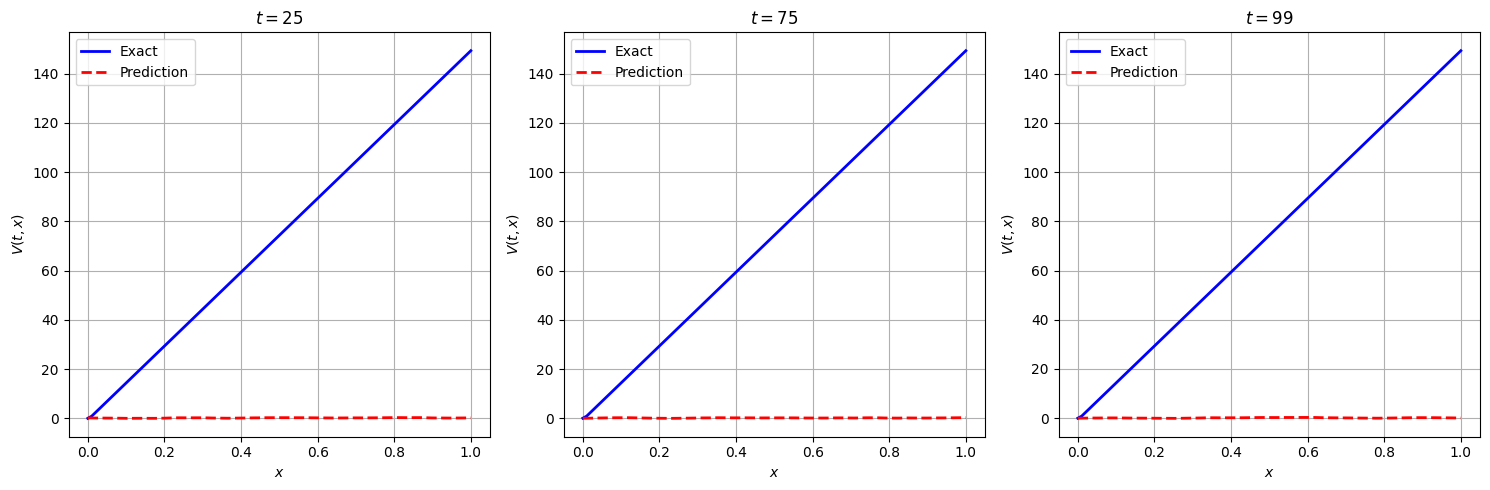

In [12]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 75, 99]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(S_pred, t_slice)
    V_pred_slice = V_pred[:, t_slice]

    # Compute exact solution
    V_exact_slice = V_exact[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(S.numpy(), V_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(S.numpy(), V_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$x$")
    plt.ylabel("$V(t, x)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
